In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import measure, feature, color
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
from skimage.feature import local_binary_pattern
from scipy.stats import skew, kurtosis
from scipy.ndimage import label
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# List of complete paths for images and masks
image_paths = sorted(glob('/kaggle/input/ham1000-segmentation-and-classification/images/*.jpg')) \
            + sorted(glob('/kaggle/input/ham1000-segmentation-and-classification/images/*.png'))

mask_paths = sorted(glob('/kaggle/input/ham1000-segmentation-and-classification/masks/*.png')) \
           + sorted(glob('/kaggle/input/ham1000-segmentation-and-classification/masks/*.jpg'))

print(f"Total images: {len(image_paths)}")
print(f"Total masks: {len(mask_paths)}")

Total images: 10015
Total masks: 10015


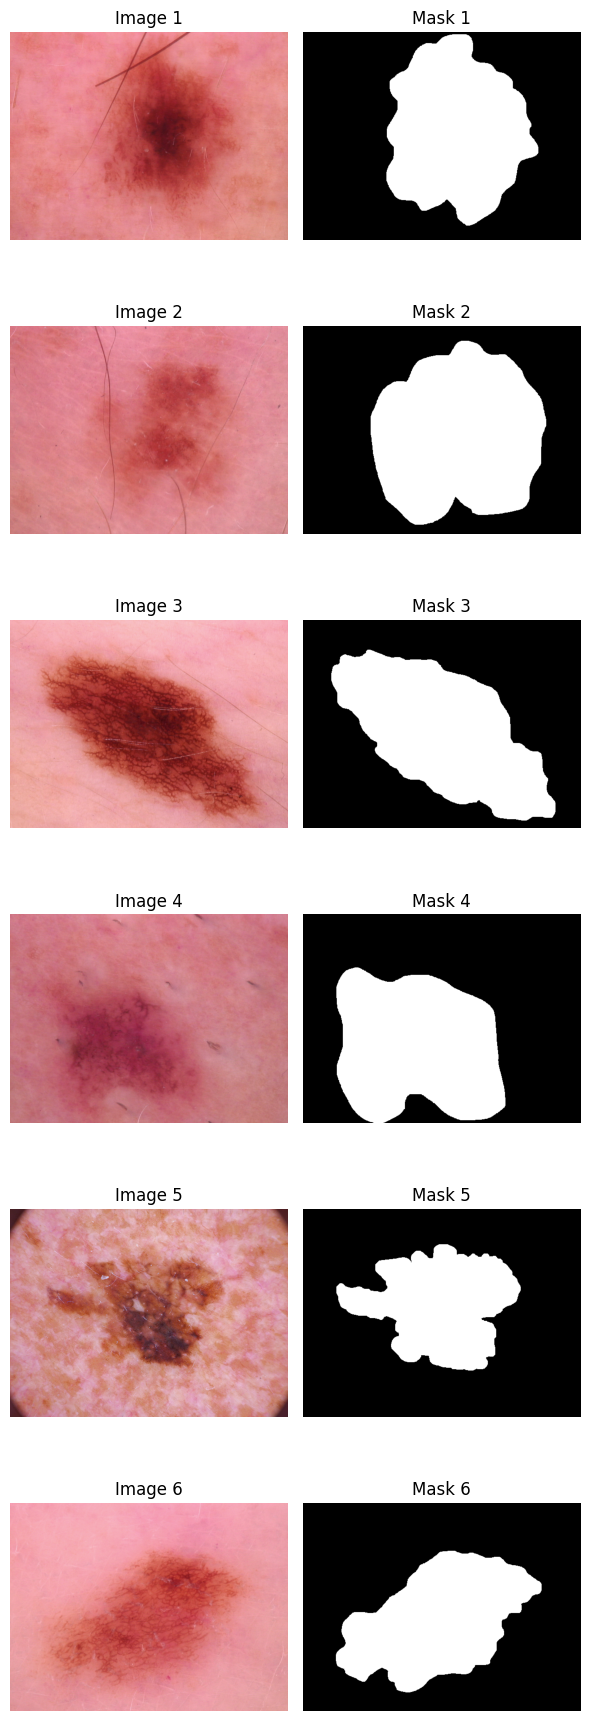

In [3]:
n = 6  # Number of images/masks you want to visualize
plt.figure(figsize=(6, n*3))

for i in range(n):
    # Load image and mask
    img = Image.open(image_paths[i])
    mask = Image.open(mask_paths[i])

    # Convert to numpy array for easier visualization if needed
    img = np.array(img)
    mask = np.array(mask)

    # Show the image
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Show the mask
    plt.subplot(n, 2, 2*i+2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


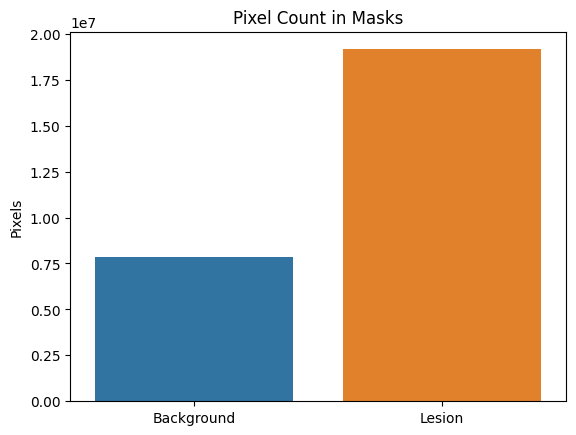

In [4]:
total_lesion = 0
total_background = 0
sample_n = 100  # Number of masks to use (can increase, but may be slow)

for i in range(min(sample_n, len(mask_paths))):
    mask = np.array(Image.open(mask_paths[i]))
    # If the mask is RGB, convert it to a single channel
    if mask.ndim == 3:
        mask = mask[...,0]
    total_lesion += np.sum(mask > 0)
    total_background += np.sum(mask == 0)

sns.barplot(x=['Background', 'Lesion'], y=[total_background, total_lesion])
plt.title('Pixel Count in Masks')
plt.ylabel('Pixels')
plt.show()

In [5]:
# Define feature extraction function
def extract_features(image_path, mask_path):
    # Load image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    
    # Ensure mask is binary (assuming 0 and 255)
    mask = mask > 0
    
    # Shape features using regionprops
    props = measure.regionprops(mask.astype(int))[0]
    area = props.area
    perimeter = props.perimeter
    major_axis = props.major_axis_length
    minor_axis = props.minor_axis_length
    aspect_ratio = major_axis / minor_axis if minor_axis > 0 else 0
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    compactness = (perimeter ** 2) / area if area > 0 else 0
    diameter = major_axis  # Approximation of lesion diameter
    eccentricity = props.eccentricity
    solidity = props.solidity
    extent = props.extent
    equivalent_diameter = props.equivalent_diameter
    
    # Texture features using GLCM
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    min_row, min_col, max_row, max_col = props.bbox
    grayscale_cropped = grayscale[min_row:max_row, min_col:max_col]
    glcm = graycomatrix(grayscale_cropped, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    asm = graycoprops(glcm, 'ASM').mean()
    entropy_glcm = -np.sum(glcm * np.log2(glcm + np.finfo(float).eps))  # GLCM entropy
    
    # LBP features
    lbp = local_binary_pattern(grayscale_cropped, P=8, R=1, method='uniform')
    lbp_mean = np.mean(lbp)
    lbp_variance = np.var(lbp)
    
    # Edge density using Canny
    edges = cv2.Canny(grayscale_cropped, 100, 200)
    edge_density = np.sum(edges > 0) / (edges.size + np.finfo(float).eps)
    
    # Color features
    lesion_r = image[:, :, 0][mask]
    lesion_g = image[:, :, 1][mask]
    lesion_b = image[:, :, 2][mask]
    mean_r = np.mean(lesion_r)
    mean_g = np.mean(lesion_g)
    mean_b = np.mean(lesion_b)
    var_r = np.var(lesion_r)
    var_g = np.var(lesion_g)
    var_b = np.var(lesion_b)
    lesion_grayscale = grayscale[mask]
    std_grayscale = np.std(lesion_grayscale)
    skewness_grayscale = skew(lesion_grayscale) if len(lesion_grayscale) > 0 else 0
    kurtosis_grayscale = kurtosis(lesion_grayscale) if len(lesion_grayscale) > 0 else 0
    # Color histogram entropy
    hist, _ = np.histogram(lesion_grayscale, bins=256, range=(0, 256), density=True)
    color_entropy = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
    
    # Boundary features
    # Simple fractal dimension for border irregularity
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = contours[0]
        perimeter_points = len(contour)
        log_perimeter = np.log(perimeter_points + 1)
        log_area = np.log(area + 1)
        fractal_dimension = 2 * log_perimeter / (log_perimeter + log_area) if log_perimeter > 0 else 0
    else:
        fractal_dimension = 0
    
    # Asymmetry index
    centroid = props.centroid
    cx, cy = int(centroid[1]), int(centroid[0])
    mask_flipped = np.flipud(mask)  # Flip vertically for asymmetry
    intersection = np.logical_and(mask, mask_flipped)
    union = np.logical_or(mask, mask_flipped)
    asymmetry_index = 1 - (np.sum(intersection) / (np.sum(union) + np.finfo(float).eps))
    
    # Perimeter-to-area ratio
    perimeter_to_area = perimeter / area if area > 0 else 0
    
    # Image identifier
    image_id = os.path.basename(image_path).split('.')[0]
    
    # Return features as a dictionary
    return {
        'image_id': image_id,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'aspect_ratio': aspect_ratio,
        'compactness': compactness,
        'diameter': diameter,
        'eccentricity': eccentricity,
        'solidity': solidity,
        'extent': extent,
        'equivalent_diameter': equivalent_diameter,
        'contrast': contrast,
        'correlation': correlation,
        'energy': energy,
        'homogeneity': homogeneity,
        'dissimilarity': dissimilarity,
        'asm': asm,
        'entropy_glcm': entropy_glcm,
        'lbp_mean': lbp_mean,
        'lbp_variance': lbp_variance,
        'edge_density': edge_density,
        'mean_r': mean_r,
        'mean_g': mean_g,
        'mean_b': mean_b,
        'var_r': var_r,
        'var_g': var_g,
        'var_b': var_b,
        'std_grayscale': std_grayscale,
        'skewness_grayscale': skewness_grayscale,
        'kurtosis_grayscale': kurtosis_grayscale,
        'color_entropy': color_entropy,
        'fractal_dimension': fractal_dimension,
        'asymmetry_index': asymmetry_index,
        'perimeter_to_area': perimeter_to_area
    }

# Extract features for all images
feature_list = []
for img_path, mask_path in zip(image_paths, mask_paths):
    features = extract_features(img_path, mask_path)
    feature_list.append(features)

# Convert to DataFrame
df = pd.DataFrame(feature_list)

# Save to CSV
output_path = '/kaggle/working/features.csv'
df.to_csv(output_path, index=False)
print(f"Features saved to {output_path}")

Features saved to /kaggle/working/features.csv
